在GP应用场景中，一个常见的情况是对于多树GP，我们需要每棵GP树使用不同的算子或变量。例如，在下面这篇TEVC论文中：

[TEVC 2024 "Modular Multi-Tree Genetic Programming for Evolutionary Feature Construction for Regression"](./Modular_Multitree_Genetic_Programming_for_Evolutionary_Feature_Construction_for_Regression.pdf)

多棵GP树需要不同算子的情况在运筹优化、图像处理等领域也是很常见的。

这篇文章主要讲述如何在GP中实现多棵GP树，每棵GP树使用不同的算子或变量。介绍了一种新的机器学习方法,叫做模块化多树遗传编程(Modular Multitree Genetic Programming, MMTGP),主要用于回归问题中的特征构建。

主要创新点：

1. 提出了一种新的模块化表示方法：允许后面的GP树使用前面GP树的输出作为输入,从而形成一个分层模块化的结构。

2. 引入了三个约束条件来提高搜索效率：
- 范围约束:限制每个GP树只能使用前v个树的输出
- 层次约束:高层树只能使用低层树的输出
- 滑动窗口连接:使用滑动窗口方式而不是层到层的连接方式

3. 提出了几个策略来改进算法性能：
- 宏观父代修复策略:减少冗余和不相关特征
- 宏观交叉算子:保持特征之间的交互关系  
- 自适应参数控制策略:动态平衡探索与利用

实验结果：

1. 在98个回归数据集上与7种代码膨胀控制方法进行比较,结果显示MMTGP在测试性能和模型大小上都取得了显著better的结果。

2. 在最新的符号回归基准测试中,提出的方法超越了22种现有的符号回归和机器学习算法。

举个例子：

在传统的遗传编程(GP)中，每个个体(或者说每棵树)都可以使用所有允许的运算符(比如加减乘除)。运算符的选择不是主要区别。

MMTGP的创新点在于它的分层和模块化结构：

假设我们要预测房价，有以下原始特征：
- x1: 房屋面积
- x2: 卧室数量
- x3: 建造年份

在传统GP中，每棵树都是独立的，只能直接使用这些原始特征。比如：
```
树1: (x1 + x2) * x3
树2: x1 * x2 / x3
```

而在MMTGP中，后面的树可以使用前面树的计算结果。比如：
```
树1: φ1 = x1 + x2         (基础特征：面积和卧室的和)
树2: φ2 = x1 * x2         (基础特征：面积和卧室的乘积)
树3: φ3 = φ1 * φ2        (高层特征：使用前面计算的φ1和φ2)
```

这种设计的优势是：
1. 可以重用已经计算出的有用特征组合
2. 通过分层构建更复杂的特征
3. 减少重复计算，使得最终模型更紧凑

这种模块化的方法让特征构建变得更有效率，也更容易产生有意义的复杂特征。

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression

# 糖尿病数据集
X, y = load_diabetes(return_X_y=True)


# 求解问题的目标是最大化回归精度
def evalFeatureEngineering(individuals,psets):
    """
    评估遗传编程构造的特征的质量
    individuals: 一组GP树，每棵树代表一个特征构造函数
    psets: 每棵树对应的原始特征集
    """
    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(individuals):
        func = gp.compile(expr=ind, pset=psets[ind_num])
        results = func(*X.T)
        # 如果结果是标量，扩展成向量
        if results.size == 1:
            results=np.full(X.shape[0], results)
        new_features.append(results)

    # 使用交叉验证计算误差
    new_features = np.transpose(np.array(new_features))
    clf = LinearRegression()
      # 使用5折交叉验证评估模型性能
    scores = cross_val_score(clf, new_features, y, cv=5)

    # 返回平均分类精度
    return (scores.mean(),)

### 创建多个Primitive Set
在GP中，不同树使用不同算子是一个常见的场景。为此，一个简单的方法是创建多个Primitive Set，每个Primitive Set对应一棵树所使用的Functions和Terminals。

In [2]:
import operator
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from sklearn.model_selection import cross_val_score

# 创建GP框架的基本组件
psets=[]
# 创建5个不同的原语集，每个对应一棵树
for idx in range(5):
    pset = gp.PrimitiveSet("MAIN", X.shape[1])
    if idx==0:
        # 第一棵树(idx=0)有更丰富的函数集，包含三角函数
        pset.addPrimitive(np.add, 2)
        pset.addPrimitive(np.subtract, 2)
        pset.addPrimitive(np.multiply, 2)
        pset.addPrimitive(np.sin, 1)
        pset.addPrimitive(np.cos, 1)
    else:
        # 其他树使用更简单的函数集
        pset.addPrimitive(np.add, 2)
        pset.addPrimitive(np.subtract, 2)
        pset.addPrimitive(np.multiply, 2)
        pset.addPrimitive(np.negative, 1)
    """
    第一棵树可以构造更复杂的非线性特征
    后续的树可以基于这些复杂特征进行简单组合
    """
    pset.addEphemeralConstant("rand101", lambda: random.random() * 2 - 1)
    psets.append(pset)


# 创建一个适应度类和个体类，个体由多棵树组成
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/home/glk/project/anaconda3/lib/python3.11/site-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


### 定义算子
由于定义了多个Primitive Set，我们需要对相关算子进行修改，以处理多个Primitive Set的情况。简单来说，主要是修改初始化和变异算子。

In [3]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, min_=1, max_=6)


# 初始化每个个体为一个包含多棵树的列表
def initIndividual(container, func, size):
    """
    创建一个包含多棵树的个体
    container: 个体的容器类型（这里是我们之前定义的Individual类）
    func: 用于生成树的函数
    size: 需要生成的树的数量
    """
    return container(gp.PrimitiveTree(func(pset=psets[idx])) for idx in range(size))


# 交叉和变异算子需要能够处理个体的列表结构
def cxOnePointListOfTrees(ind1, ind2):
    for idx, (tree1, tree2) in enumerate(zip(ind1, ind2)):
        HEIGHT_LIMIT = 10
        # 创建一个装饰器来限制树的高度
        dec = gp.staticLimit(key=operator.attrgetter("height"), max_value=HEIGHT_LIMIT)
        # 执行单点交叉，并应用高度限制
        tree1, tree2 = dec(gp.cxOnePoint)(tree1, tree2)
        ind1[idx], ind2[idx] = tree1, tree2
    return ind1, ind2


def mutUniformListOfTrees(individual, expr, psets):
    for idx, tree in enumerate(individual):
        HEIGHT_LIMIT = 10
        dec = gp.staticLimit(key=operator.attrgetter("height"), max_value=HEIGHT_LIMIT)
        # 执行均匀变异，并应用高度限制
        tree, = dec(gp.mutUniform)(tree, expr=expr, pset=psets[idx])
        individual[idx] = tree
    return (individual,)

# 假设我们创建3个特征
toolbox.register("individual", initIndividual, creator.Individual, toolbox.expr, size=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFeatureEngineering,psets=psets)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", cxOnePointListOfTrees)
toolbox.register("mutate", mutUniformListOfTrees, expr=toolbox.expr, psets=psets)
toolbox.register("compile", gp.compile)

### 运行遗传编程算法
最后，我们可以运行遗传编程算法，来看看生成的树是否是根据多个Primitive Set生成的。

In [4]:
random.seed(0)
np.random.seed(0)
# 运行遗传编程算法
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)

# 统计和日志
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
stats_size = tools.Statistics(key=lambda ind: max([tree.height for tree in ind]))
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)

# 查看最佳个体
best_ind = hof[0]
for idx, tree in enumerate(best_ind):
    print('Tree ', idx)
    print(str(tree))
print('With fitness:', best_ind.fitness.values)

   	      	                                fitness                                 	                      size                     
   	      	------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min       	nevals	std     	avg 	gen	max	min	nevals	std    
0  	50    	0.192161	0  	0.406731	-0.0324056	50    	0.118053	3.82	0  	6  	1  	50    	1.49251
1  	48    	0.252579	1  	0.457378	0.00833404	48    	0.103727	4.28	1  	8  	1  	48    	1.56256
2  	46    	0.309686	2  	0.461332	-0.0381053	46    	0.113967	4.5 	2  	10 	2  	46    	1.66433
3  	43    	0.315646	3  	0.461332	-0.0142302	43    	0.113002	4.76	3  	9  	1  	43    	2.06456
4  	46    	0.340563	4  	0.465766	0.0719396 	46    	0.0958435	4.76	4  	9  	2  	46    	2.07422
5  	48    	0.328297	5  	0.465053	-0.0378769	48    	0.123629 	5.7 	5  	10 	2  	48    	2.40208
6  	42    	0.374865	6  	0.466558	0.00764382	42    	0.0888115	6.14	6  	10 	2  	42    	2.537

分析运行结果：

输出显示了进化过程中每一代的统计信息，分为两个主要部分：适应度(fitness)和树的大小(size)。每行代表一代，包含以下信息：
- gen: 当前代数
- nevals: 本代中评估的个体数量
- avg/max/min: 适应度和树大小的统计值
- std: 标准差

演化趋势分析：

1. 适应度进化：
- 起始性能：第0代的平均适应度为0.192，最好个体为0.407
- 最终性能：到第10代，平均适应度提升到0.404，最好个体达到0.469
- 进步过程：我们可以看到适应度在前几代快速提升，后期趋于稳定
- 最终结果相当稳定，标准差从初始的0.118降低到0.072，说明种群趋于收敛

2. 树的大小演化：
- 树的大小从平均3.82节点增长到7.12节点
- 标准差增加表明不同个体的复杂度差异在扩大
- 树的大小增长是渐进的，没有出现爆炸性增长，说明复杂度控制有效

最终获得的最佳个体包含三棵树：

```python
# 第一棵树：使用三角函数的非线性组合
Tree 0: subtract(sin(add(ARG6, ARG8)), sin(ARG2))

# 第二棵树：包含算术运算和常数
Tree 1: subtract(ARG8, multiply(multiply(ARG8, negative(negative(0.738))), negative(ARG5)))

# 第三棵树：较复杂的算术组合
Tree 2: add(subtract(subtract(multiply(-0.879, 0.475), add(multiply(ARG3, ARG1), ARG5)), negative(ARG3)), ARG2)
```

这个结果很有趣，因为：

1. 特征构造的多样性：
- 第一棵树利用三角函数创建非线性特征
- 第二棵树关注特征间的乘法交互
- 第三棵树构建了多层次的算术组合

2. 算法的有效性：
- 最终适应度0.470说明构造的特征确实提升了回归性能
- 树的结构相对简单，避免了过度复杂化
- 不同树的功能互补，体现了多树方法的优势

3. 收敛特性：
- 适应度的稳定提升表明算法成功找到了有效的特征组合
- 最后几代的改进变缓，说明算法达到了较好的平衡点

这个结果展示了模块化多树GP在特征构造任务上的有效性，它能够构建出既有表现力又相对简洁的特征组合。不同树的功能分工明确，共同提供了一个良好的特征空间来提升回归性能。

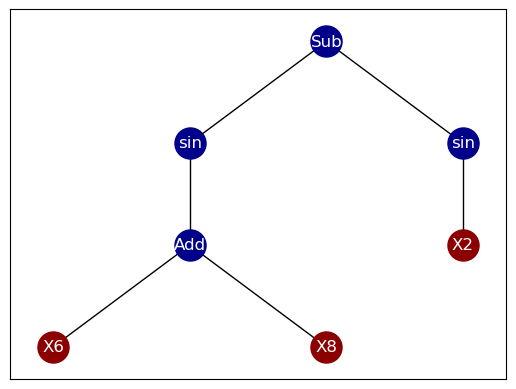

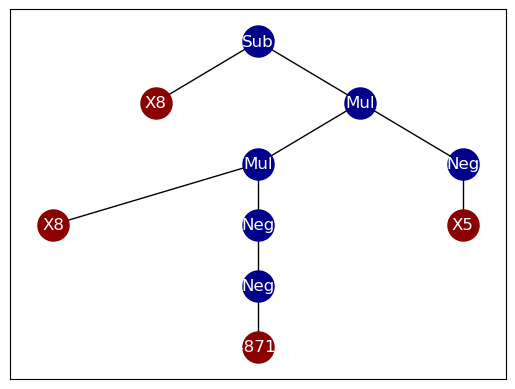

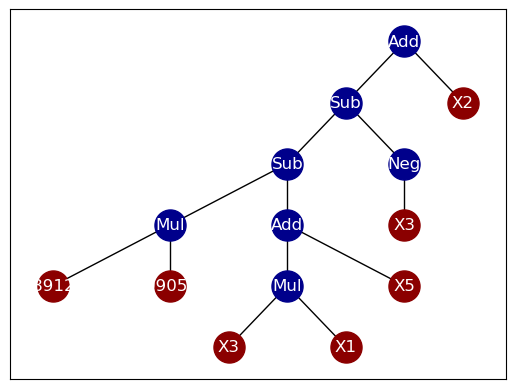

In [5]:
from matplotlib import pyplot as plt
import networkx as nx
from deap.gp import graph
from networkx.drawing.nx_agraph import graphviz_layout

function_name = {
    'add': 'Add',
    'sub': 'Sub',
    'subtract': 'Sub',
    'mul': 'Mul',
    'multiply': 'Mul',
    'neg': 'Neg',
    'sin': 'sin',
    'cos': 'cos',
    'negative': 'Neg',
}

def is_number(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

def plot_a_tree(tree=hof[0]):
    red_nodes = []
    purple_nodes = []
    blue_nodes = []
    for gid, g in enumerate(tree):
        if (
                hasattr(g, "value")
                and isinstance(g.value, str)
                and g.value.startswith("ARG")
        ):
            g.value = g.value.replace("ARG", "X")

        if g.name in function_name:
            g.name = function_name[g.name]

        if hasattr(g, "value") and (
                is_number(g.value)
                or (g.value.startswith("X") and int(g.value[1:]) < X.shape[1])
        ):
            # 基础节点
            red_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("X"):
            g.value = "$\phi$" + str(int(g.value.replace("X", "")) - X.shape[1] + 1)
            purple_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("$\phi$"):
            purple_nodes.append(gid)
        else:
            # 深蓝色节点
            blue_nodes.append(gid)
    nodes, edges, labels = graph(tree)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")
    red_nodes_idx = [nodes.index(n) for n in nodes if n in red_nodes]
    purple_nodes_idx = [nodes.index(n) for n in nodes if n in purple_nodes]
    blue_nodes_idx = [nodes.index(n) for n in nodes if n in blue_nodes]
    nx.draw_networkx_nodes(
        g, pos, nodelist=red_nodes_idx, node_color="darkred", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=purple_nodes_idx, node_color="indigo", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=blue_nodes_idx, node_color="darkblue", node_size=500
    )
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels, font_color="white")

for tree in hof[0]:
    plot_a_tree(tree)
    plt.show()

从上面的结果可以看出，每棵树使用了不同的算子。例如，第一棵树中使用了sin算子，而其他树没有使用sin算子。

基于这三棵树，让我们先写出每棵树构造的特征：

特征1 (第一棵树)：
```
φ1 = sin(X6 + X8) - sin(X2)
```
这是一个非线性特征，通过三角函数捕捉周期性模式。

特征2 (第二棵树)：
```
φ2 = X8 - (X8 × (-(-(0.871))) × (-X5))
```
简化一下：
```
φ2 = X8 - (X8 × 0.871 × (-X5))
φ2 = X8 + 0.871 × X8 × X5
```

特征3 (第三棵树)：
```
φ3 = [sub(mul(-0.891, 0.905), add(mul(X3, X1), X5)) - (-X3)] + X2
```
简化后：
```
φ3 = (-0.891 × 0.905) - (X3 × X1 + X5) + X3 + X2
φ3 = -0.806 - (X3 × X1 + X5) + X3 + X2
```

最终的模型是这三个特征的线性组合：
```
y = w1×φ1 + w2×φ2 + w3×φ3 + b
```
其中w1、w2、w3是通过线性回归学习到的权重，b是偏置项。

这种设计非常巧妙，因为：
1. φ1通过三角函数捕捉非线性关系
2. φ2专注于特征间的乘法交互
3. φ3包含了多个特征的线性和非线性组合

**注意：这里没有演化出`φ3 = φ1 * φ2`这样的特征，是因为我们演化出的φ3更适者生存**

在MMTGP中,我们给了算法重用特征的能力(就像φ3 = φ1 * φ2这样),但最终的演化结果会取决于"适应度"评估。对于这个具体的回归问题,算法发现了一个更好的特征组合方式。

让我们比较这两种可能的特征构造方式：

可能的方式1：
```
φ3 = φ1 * φ2
   = [sin(X6 + X8) - sin(X2)] * [X8 + 0.871 × X8 × X5]
```
这种方式虽然体现了特征重用,但可能会产生过于复杂的非线性关系,反而不利于回归问题的求解。

实际演化出的方式：
```
φ3 = -0.806 - (X3 × X1 + X5) + X3 + X2
```
这个特征虽然没有直接重用φ1和φ2,但它：
1. 结构更简单,避免了过度复杂的非线性组合
2. 直接捕捉了原始特征间的关键关系
3. 与其他两个特征形成了互补效果(第一个特征负责复杂的非线性变换,第二个特征处理乘法交互,这个特征则关注加减法组合)

这个结果很好地展示了遗传编程的核心思想：有时候,一个相对简单但有效的特征组合可能比复杂的特征重用更适合解决具体问题。

这也提醒我们：虽然MMTGP提供了特征重用的能力,但这只是一种可能性,不是必然选择。算法会根据问题的具体需求,选择最有效的特征构造方式,即使这意味着不采用特征重用。